<a href="https://colab.research.google.com/github/NathanMacktravis/Training_SG/blob/main/Adult_Census_Income_ML(For%20the%20imputation%20step).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Importing dependencies

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle
from sklearn.impute import KNNImputer
from scipy.stats import chi2_contingency

# 2) Collecting data & describe features

In [ ]:
df = pd.read_csv('/content/adult.csv')

In [ ]:
df.head(10)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K
7,74,State-gov,88638,Doctorate,16,Never-married,Prof-specialty,Other-relative,White,Female,0,3683,20,United-States,>50K
8,68,Federal-gov,422013,HS-grad,9,Divorced,Prof-specialty,Not-in-family,White,Female,0,3683,40,United-States,<=50K
9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,?,>50K


In [ ]:
# The list of columns
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')

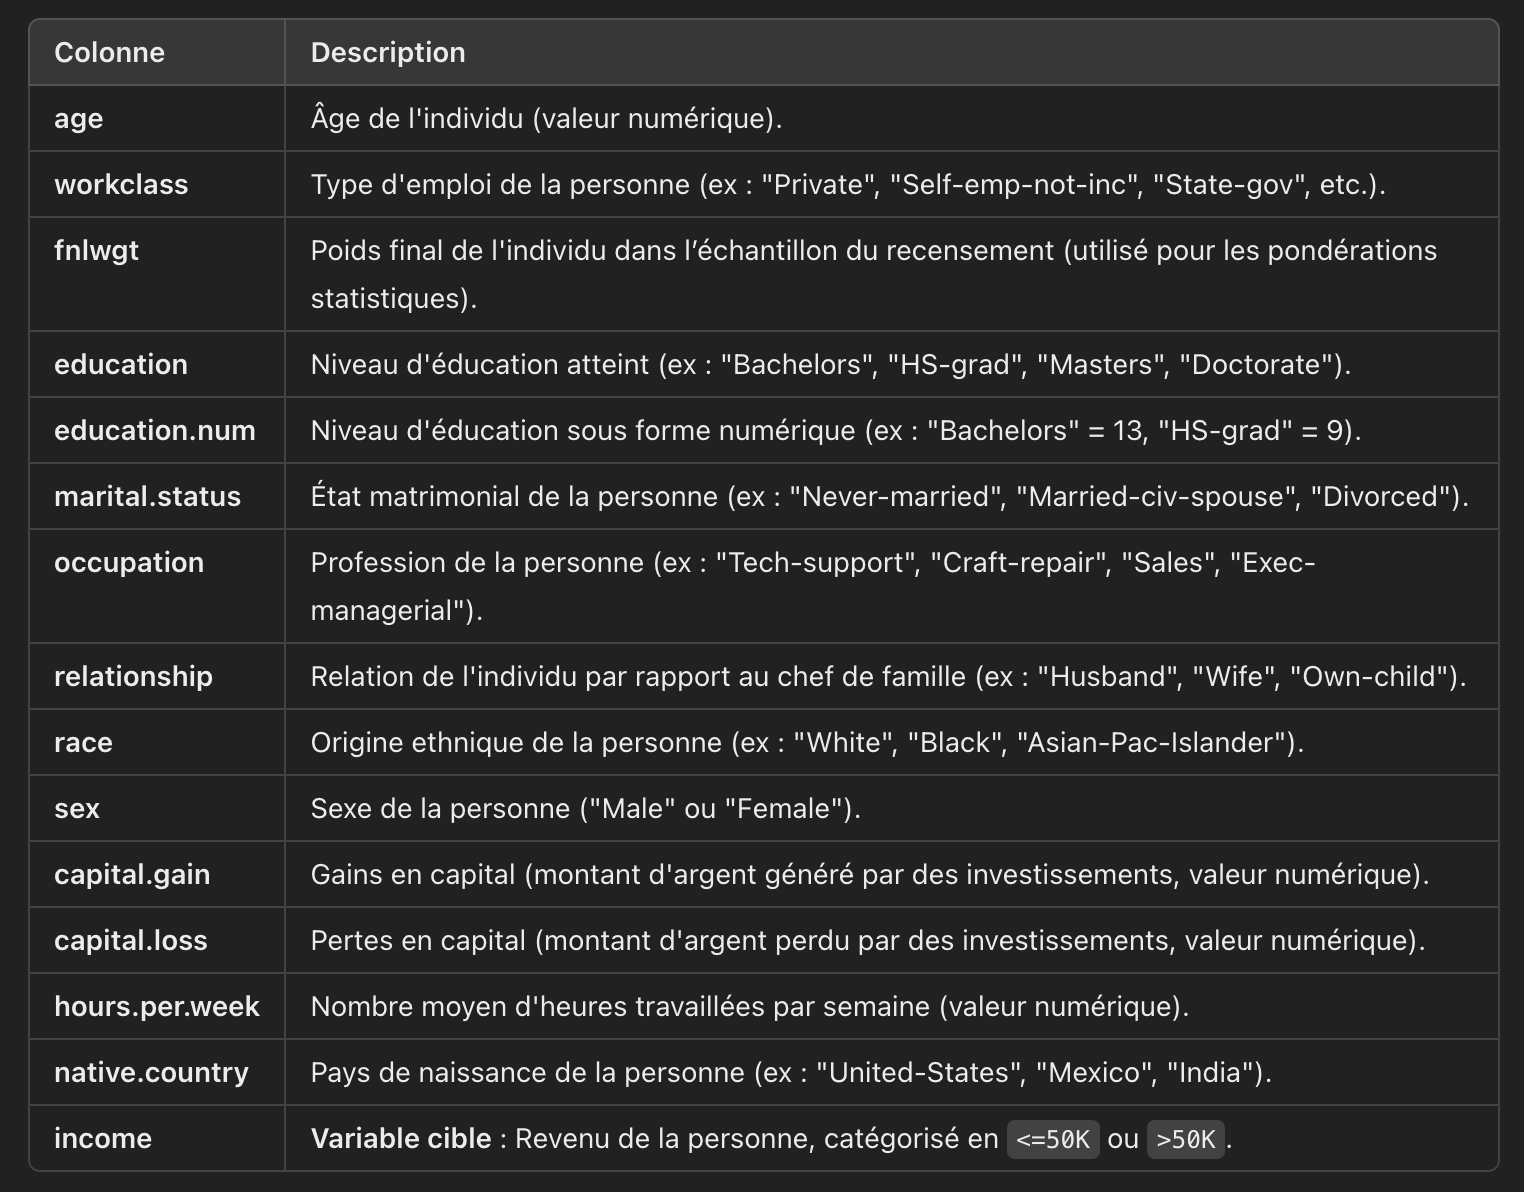

In [ ]:
# The shape of the dataset
df.shape

(32561, 15)

# 3) Exploratory data analysis

## a) Column analysis

In [ ]:
# Get info about columns like "name", "non-null counts", "type"
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [ ]:
# print unique values in each column

# Select numerical values only
numerical_features = df.select_dtypes(include=['number']).columns

# Browsing and exlude numerical columns
for col in df.columns:
    if col not in numerical_features:  # Exclut les colonnes numériques
        unique_values = df[col].unique()
        print(f"🔹 {col} ({len(unique_values)} valeurs uniques)")
        print(unique_values)  # Affiche toutes les valeurs uniques
        print("-" * 50)


🔹 workclass (9 valeurs uniques)
['?' 'Private' 'State-gov' 'Federal-gov' 'Self-emp-not-inc' 'Self-emp-inc'
 'Local-gov' 'Without-pay' 'Never-worked']
--------------------------------------------------
🔹 education (16 valeurs uniques)
['HS-grad' 'Some-college' '7th-8th' '10th' 'Doctorate' 'Prof-school'
 'Bachelors' 'Masters' '11th' 'Assoc-acdm' 'Assoc-voc' '1st-4th' '5th-6th'
 '12th' '9th' 'Preschool']
--------------------------------------------------
🔹 marital.status (7 valeurs uniques)
['Widowed' 'Divorced' 'Separated' 'Never-married' 'Married-civ-spouse'
 'Married-spouse-absent' 'Married-AF-spouse']
--------------------------------------------------
🔹 occupation (15 valeurs uniques)
['?' 'Exec-managerial' 'Machine-op-inspct' 'Prof-specialty'
 'Other-service' 'Adm-clerical' 'Craft-repair' 'Transport-moving'
 'Handlers-cleaners' 'Sales' 'Farming-fishing' 'Tech-support'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']
--------------------------------------------------
🔹 relationshi

## b) Dristribution analysis

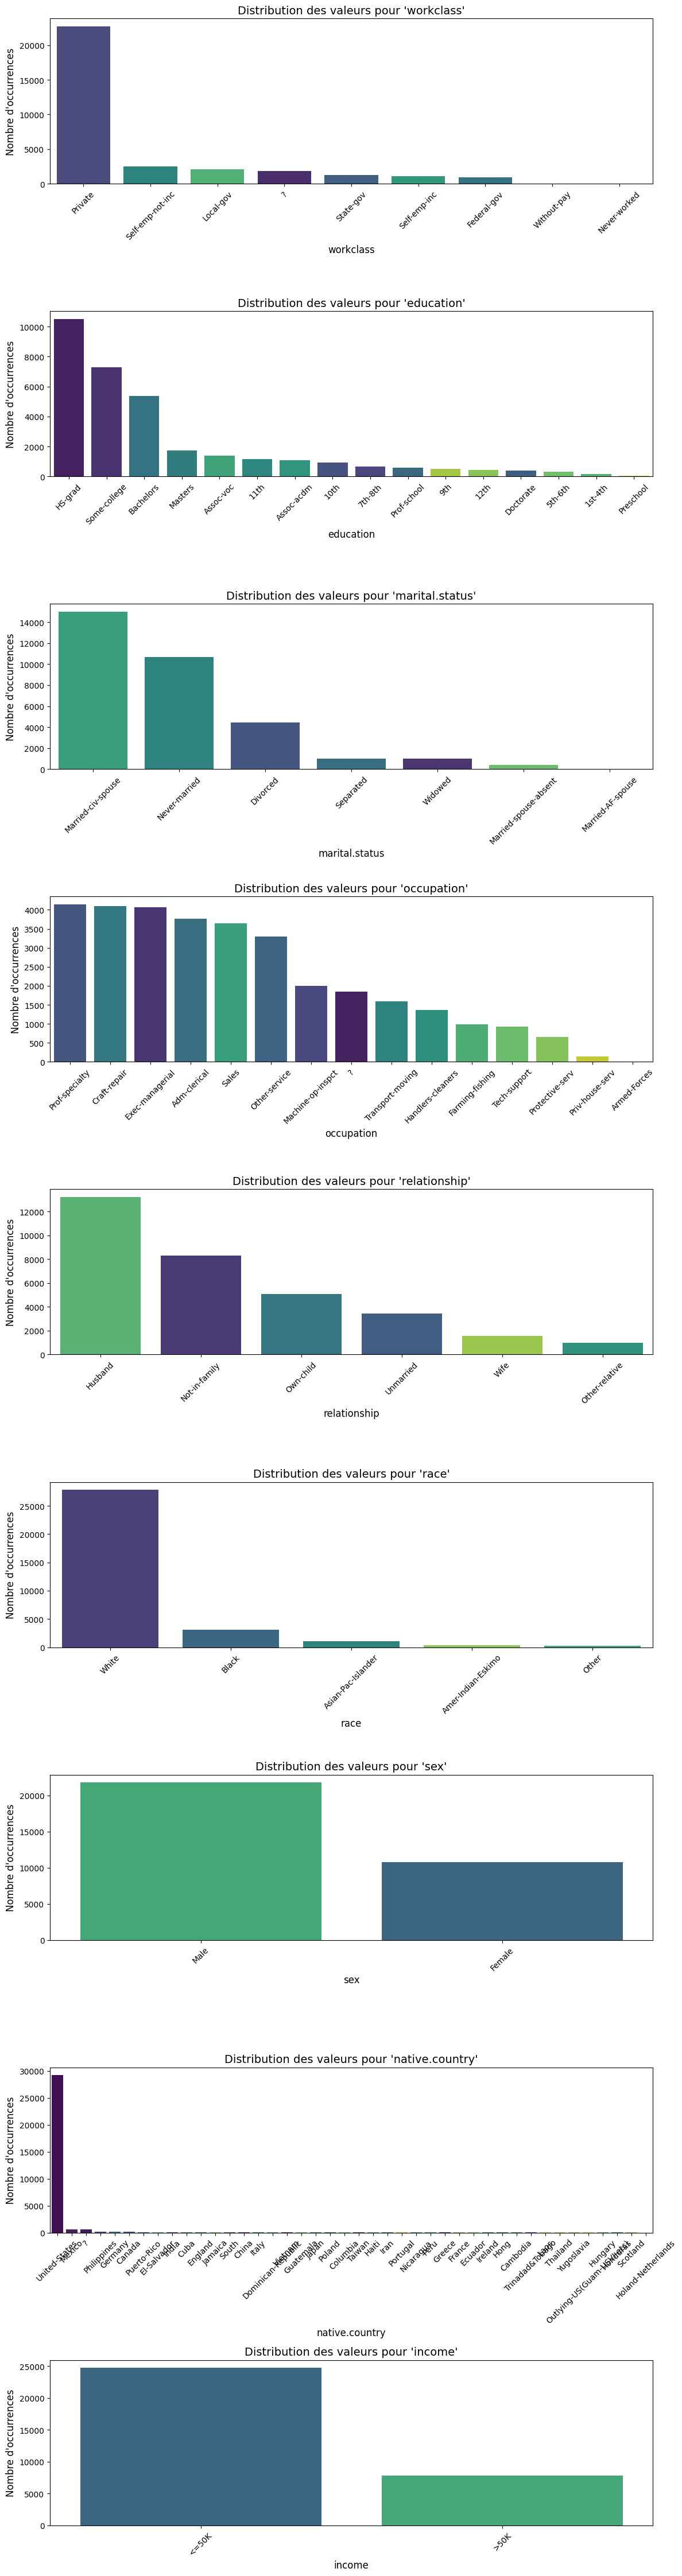

In [ ]:
## distribution values for each categorical column


categorical_features = df.select_dtypes(include=['object', 'category']).columns

# Définir la taille de la figure en fonction du nombre de colonnes catégoriques
num_cols = len(categorical_features)
fig, axes = plt.subplots(nrows=num_cols, figsize=(12, 5 * num_cols))

# Si une seule colonne catégorielle, on ajuste pour éviter une erreur d'affichage
if num_cols == 1:
    axes = [axes]

# Création des graphiques avec Seaborn
for ax, col in zip(axes, categorical_features):
    sns.countplot(data=df, x=col, hue=col, legend=False, order=df[col].value_counts().index, palette="viridis", ax=ax)
    ax.set_title(f"Distribution des valeurs pour '{col}'", fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel("Nombre d'occurrences", fontsize=12)
    ax.tick_params(axis='x', rotation=45)  # Rotation des labels pour une meilleure lisibilité

# Ajuster l'espace entre les sous-graphiques
plt.tight_layout()
plt.show()

In [ ]:
# Statitical analysis for numeric values
df.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


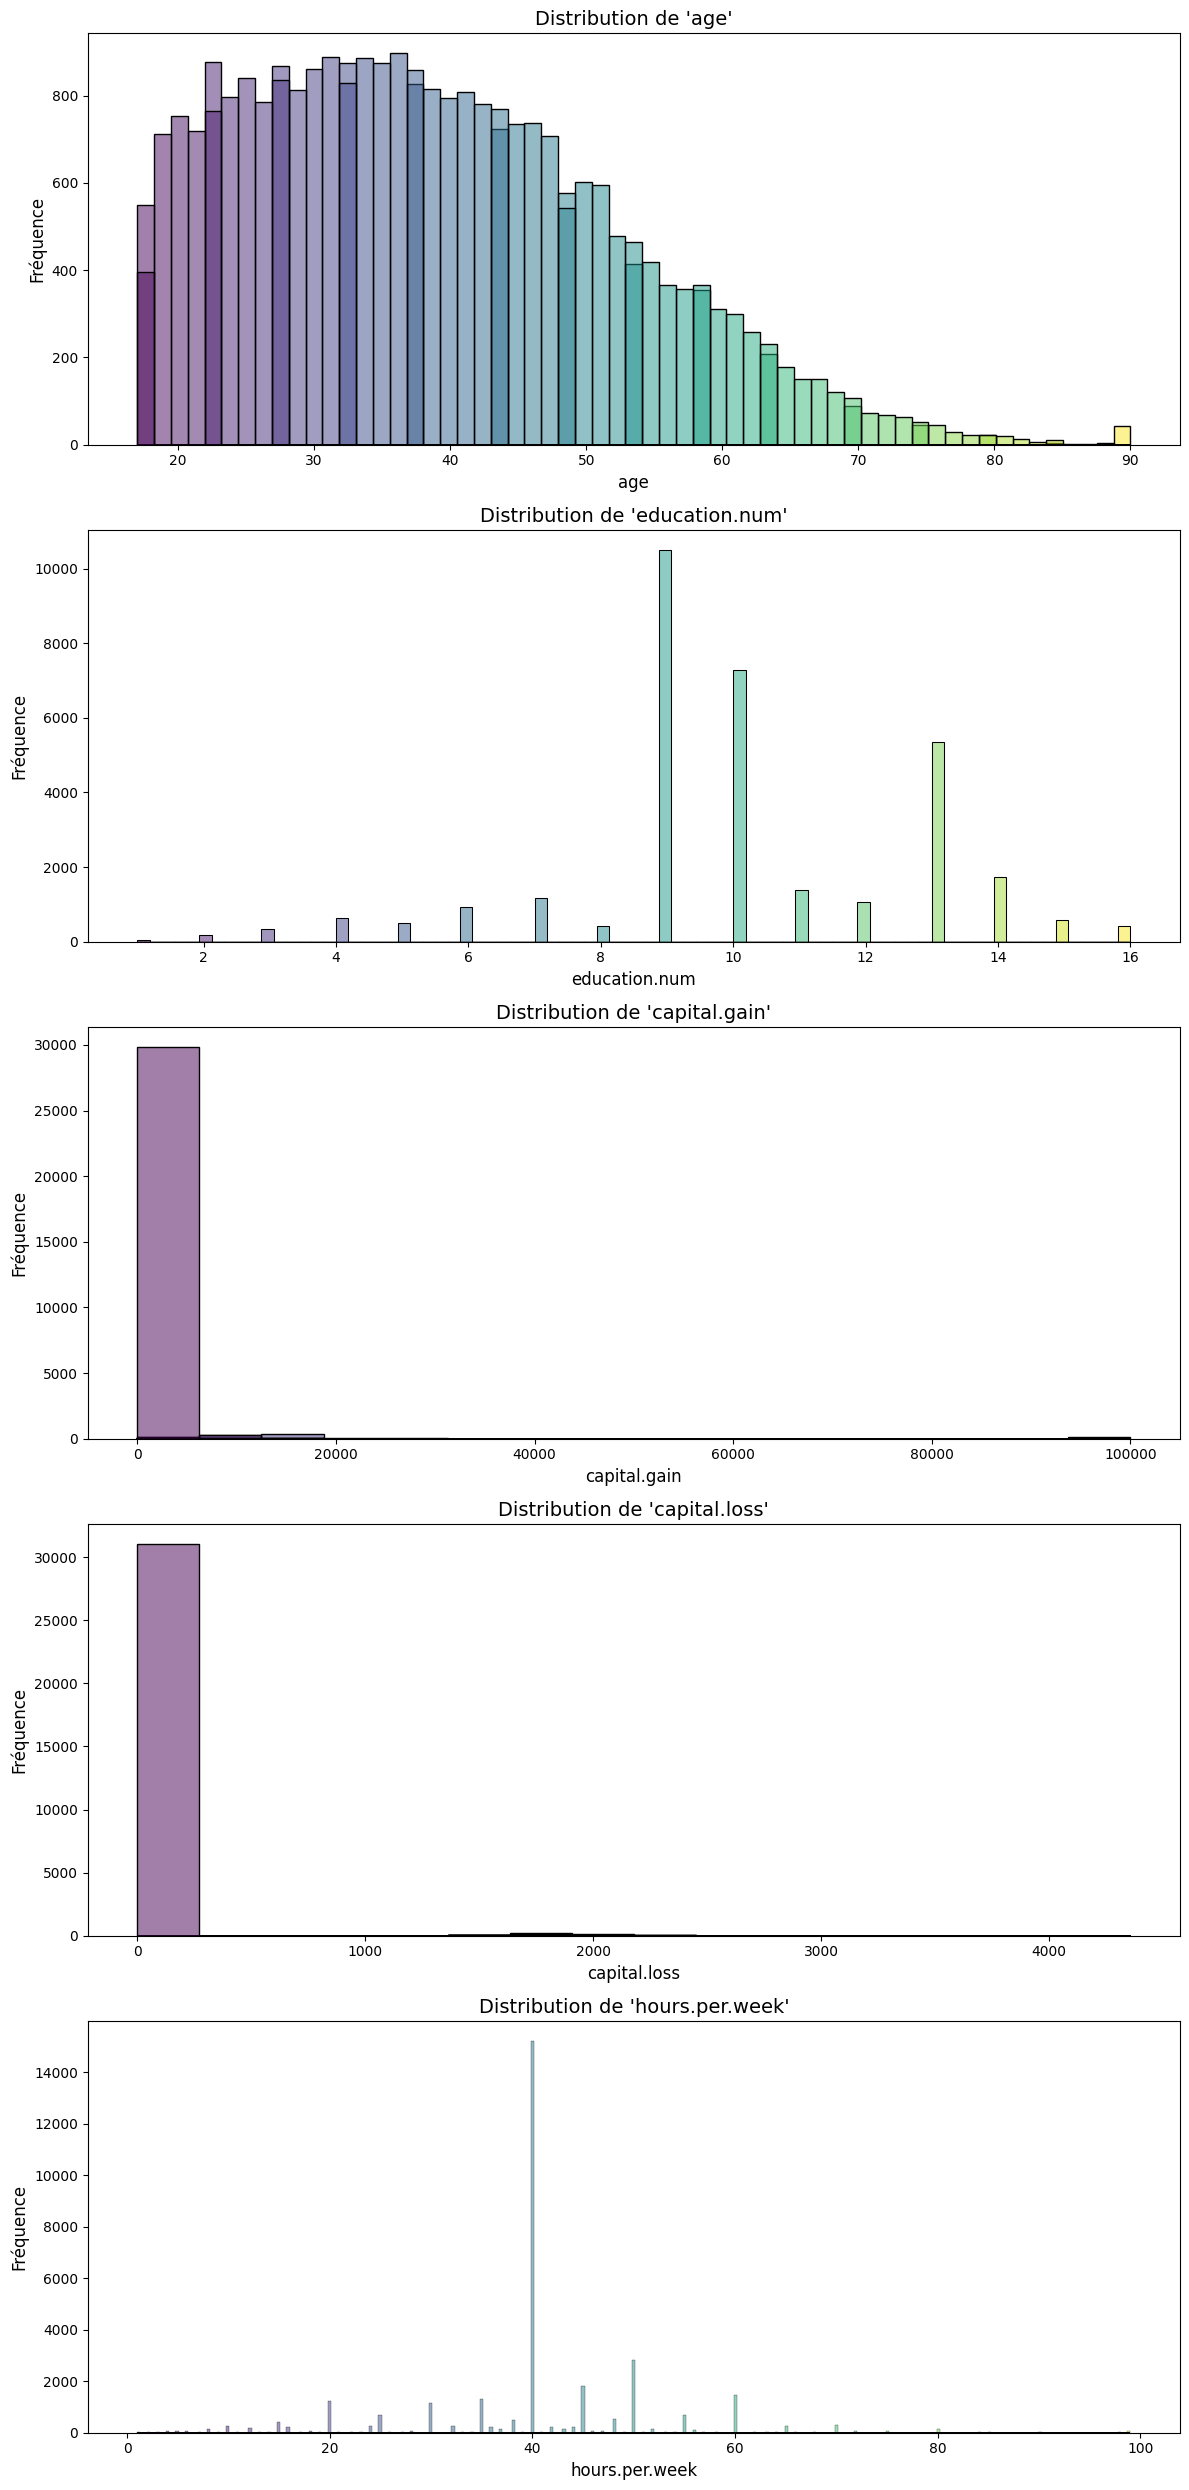

In [ ]:
## Distribution values for each numerical column


numerical_features = ['age','education.num','capital.gain','capital.loss','hours.per.week']

# Définir la taille de la figure en fonction du nombre de colonnes numériques
num_cols = len(numerical_features)
fig, axes = plt.subplots(nrows=num_cols, figsize=(12, 5 * num_cols))

# Si une seule colonne numérique, on ajuste pour éviter une erreur d'affichage
if num_cols == 1:
    axes = [axes]

# Création des histogrammes avec Seaborn
for ax, col in zip(axes, numerical_features):
    sns.histplot(data=df, x=col, hue=col, legend=False, kde=True, palette="viridis", ax=ax)
    ax.set_title(f"Distribution de '{col}'", fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel("Fréquence", fontsize=12)

# Ajuster l'espace entre les sous-graphiques
plt.tight_layout()
plt.show()

## c) Outliers analysis

<ipython-input-12-8f6005e8200d>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col, palette="viridis", ax=ax)
<ipython-input-12-8f6005e8200d>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col, palette="viridis", ax=ax)
<ipython-input-12-8f6005e8200d>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col, palette="viridis", ax=ax)
<ipython-input-12-8f6005e8200d>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` a

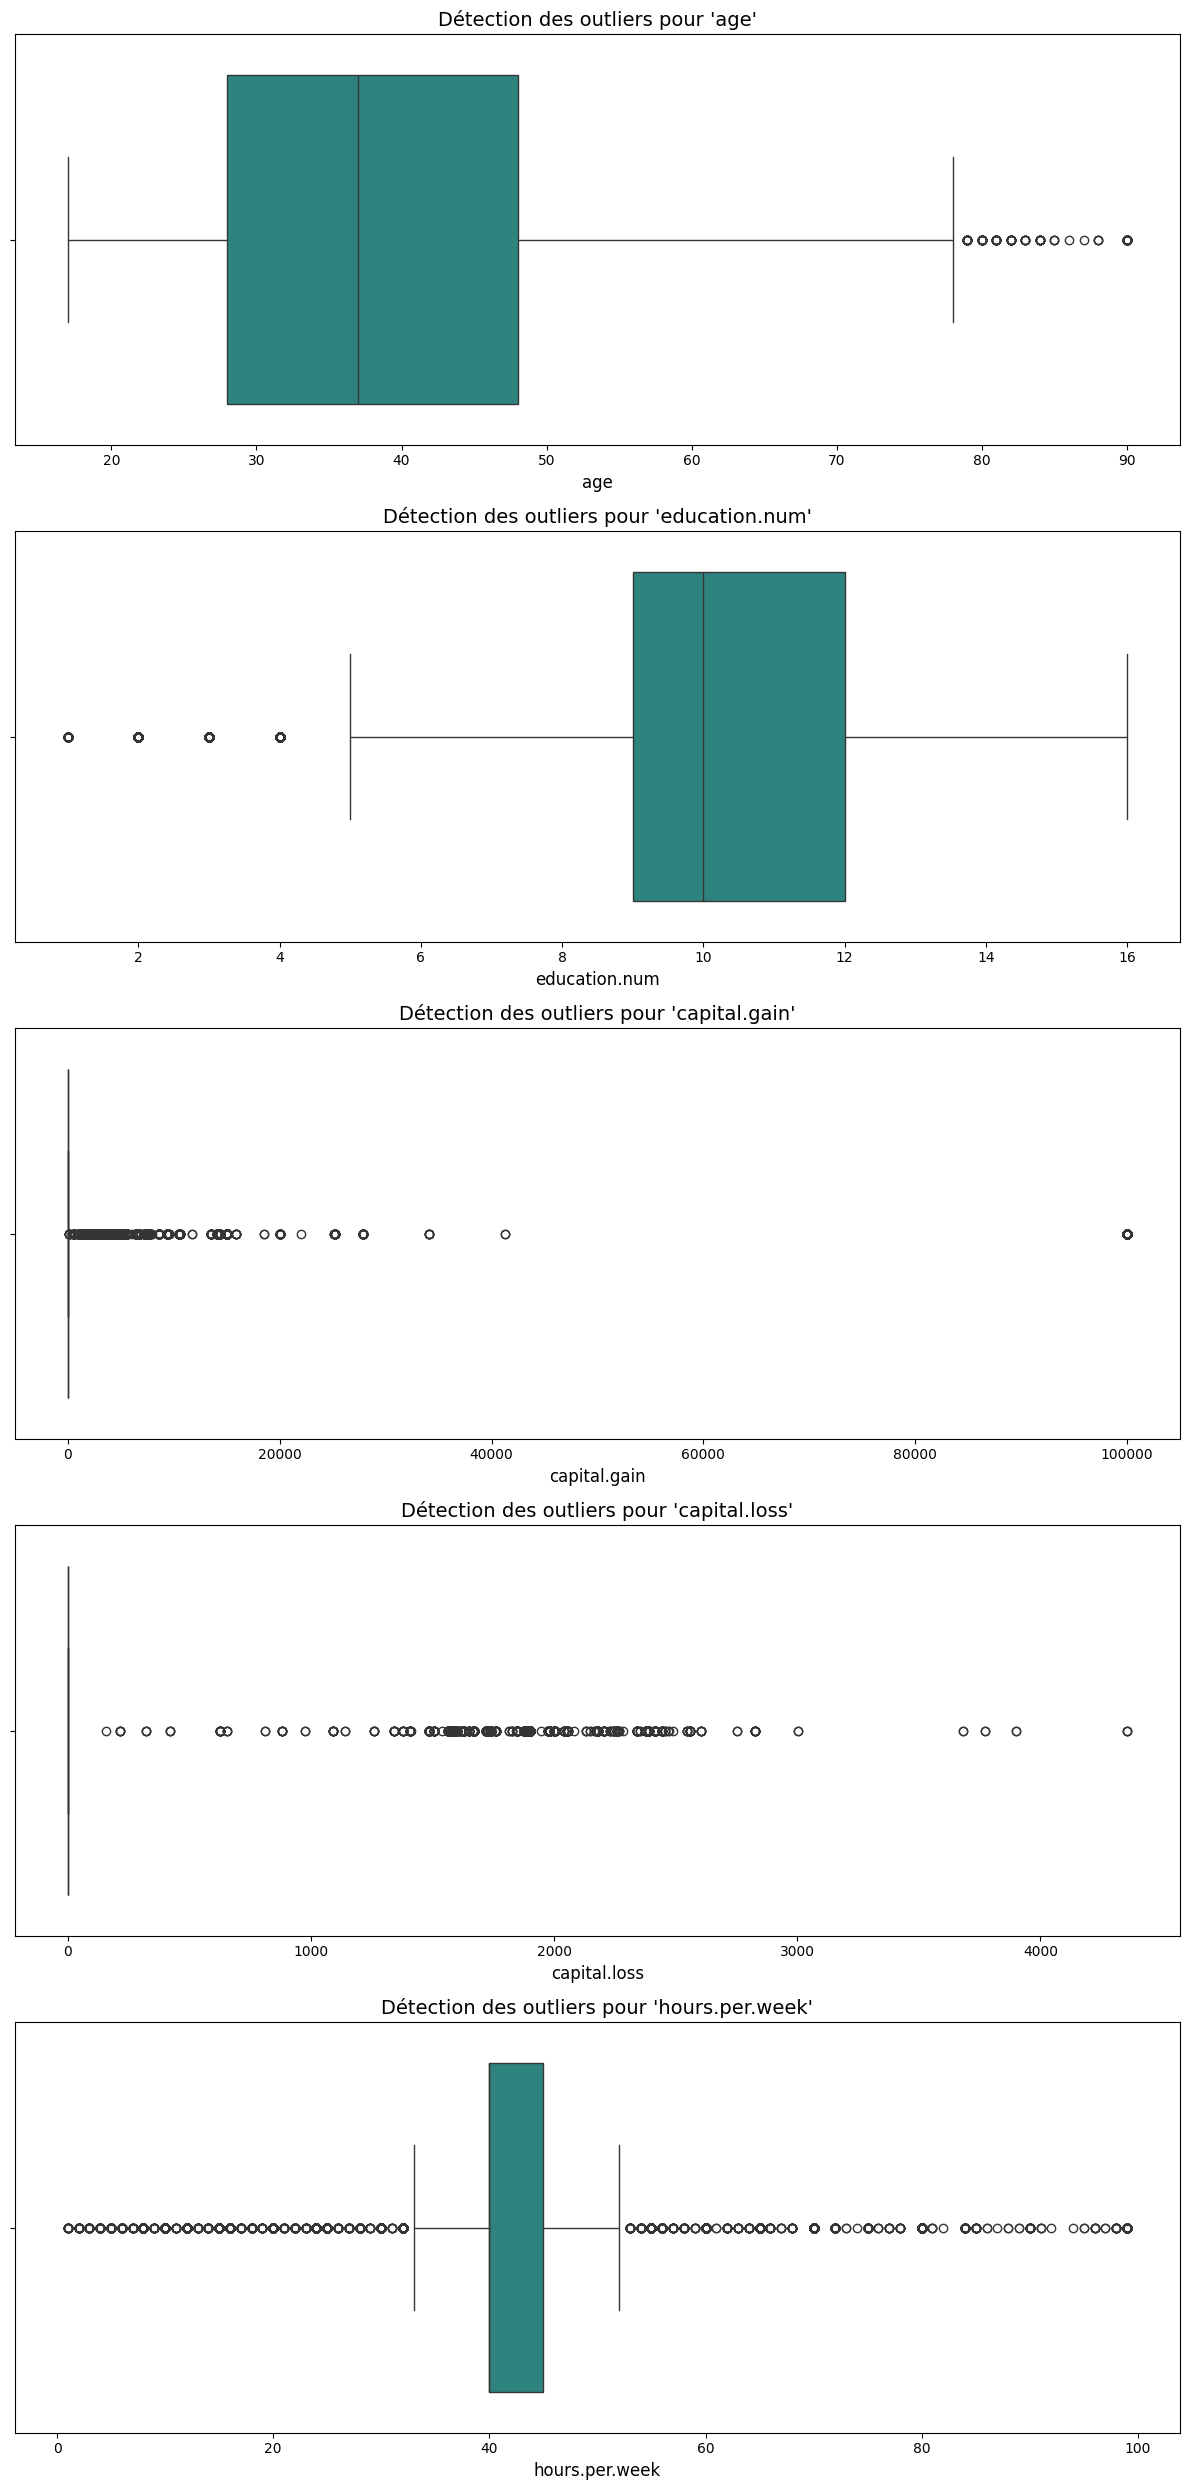

In [ ]:
## Visualization of outliers for numerical_features

# Définir la taille de la figure en fonction du nombre de colonnes numériques
num_cols = len(numerical_features)
fig, axes = plt.subplots(nrows=num_cols, figsize=(12, 5 * num_cols))

# Si une seule colonne numérique, on ajuste pour éviter une erreur d'affichage
if num_cols == 1:
    axes = [axes]

# Création des boxplots avec Seaborn
for ax, col in zip(axes, numerical_features):
    sns.boxplot(data=df, x=col, palette="viridis", ax=ax)
    ax.set_title(f"Détection des outliers pour '{col}'", fontsize=14)
    ax.set_xlabel(col, fontsize=12)

# Ajuster l'espace entre les sous-graphiques
plt.tight_layout()
plt.show()

## d) Missing values analysis

In [ ]:
df_missing_values = df.replace("?", np.nan)

In [ ]:
# Analyzing missing values
df_missing_values.isnull().sum()

,0
age,0
workclass,1836
fnlwgt,0
education,0
education.num,0
marital.status,0
occupation,1843
relationship,0
race,0
sex,0


## e) Correlations beetween features

<Axes: >

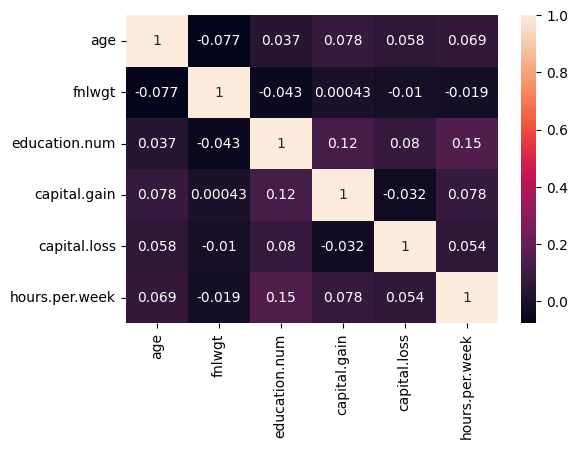

In [ ]:
# Analysis of correlations for numerical features
plt.figure(figsize=(6,4))
sns.heatmap(df[df.select_dtypes(include=['number']).columns].corr(), annot=True)

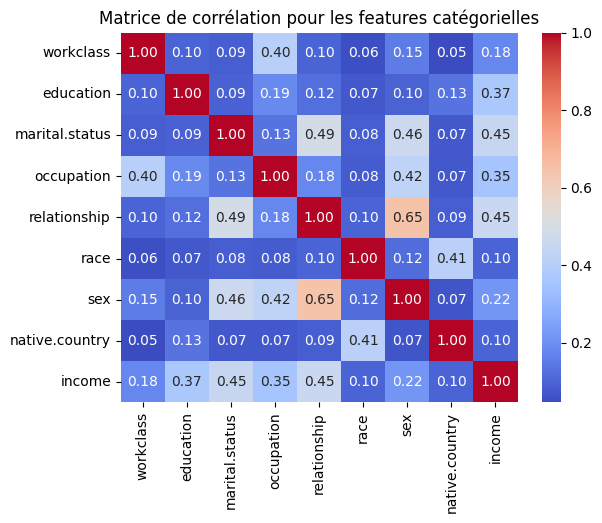

In [ ]:
# Fonction pour calculer le coefficient de Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))


# Sélectionner uniquement les colonnes catégorielles
categorical_features = df.select_dtypes(include=['object'])

# Calculer la matrice de corrélation pour les features catégorielles
correlation_matrix = pd.DataFrame(
    index=categorical_features.columns,
    columns=categorical_features.columns
)

for col1 in categorical_features.columns:
    for col2 in categorical_features.columns:
        correlation_matrix.loc[col1, col2] = cramers_v(categorical_features[col1], categorical_features[col2])

# Convertir en float pour éviter les erreurs de type
correlation_matrix = correlation_matrix.astype(float)

# Afficher la heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matrice de corrélation pour les features catégorielles")
plt.show()


Ce qu'on en tire de notre EDA:

* Les valeurs manquantes sont représentées dans notre dataset par la valeur "?" => **remplacées par le mode en fonction des coprrélations de Cramer-V**
* La nomenclature des colonnes n'est pas bonne
* Des colonnes présentes énormément de outliers => **utilisation de modèles robustes** car on ne peut pas savoir si les outliers sont naturels ou pas.
* Type d'encodage préférentiel => **Label encoding**
* La colonne **"fnlwgt"** contient énormément de valeurs uniques, donc elle va être supprimée.

# 4) Data PreProcessing

In [ ]:
df_processing_1 = df_missing_values.copy()

## a) Column treatment

In [ ]:
# Removing fnlwgt column
df_processing_1 = df_processing_1.drop(columns=['fnlwgt'])

In [ ]:
# Remplacement des points par des underscores dans les noms de colonnes
df_processing_1.rename(columns={col: col.replace('.', '_') for col in df_processing_1.columns if '.' in col}, inplace=True)

print(df_processing_1.columns)


Index(['age', 'workclass', 'education', 'education_num', 'marital_status',
       'occupation', 'relationship', 'race', 'sex', 'capital_gain',
       'capital_loss', 'hours_per_week', 'native_country', 'income'],
      dtype='object')


In [ ]:
df_processing_1.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,90,NaN,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


## b) Missing values treatment

* "workclass" : Imputation basée sur "occupation" corrélation forte(0.40).
* "occupation" : Imputation basée sur "sex" (0.42).
* "native_country" : Remplacement direct par la valeur la plus fréquente (mode), car les corrélations sont trop faibles avec les autres variables


In [ ]:
df_processing_2 = df_processing_1.copy()

### i) "*occupation*" column

In [ ]:
# Mode d'"occupation" par type de "sex"
mode_per_type = df_processing_2.pivot_table(
    values='occupation',
    columns='sex',
    aggfunc=lambda x: x.mode()[0]
)
print(mode_per_type)

sex               Female          Male
occupation  Adm-clerical  Craft-repair


In [ ]:
# We get missing values in occupation column
missing_values = df_processing_2['occupation'].isnull()

# Remplacer les valeurs manquantes
df_processing_2.loc[missing_values, 'occupation'] = df_processing_2.loc[missing_values, 'sex'].apply(lambda x: mode_per_type[x])

### ii) "workclass" column

In [ ]:
# Mode de "workclass" par type de "occupation"
mode_per_type = df_processing_2.pivot_table(
    values='workclass',
    columns='occupation',
    aggfunc=lambda x: x.mode()[0]
)
print(mode_per_type)

occupation Adm-clerical Armed-Forces Craft-repair Exec-managerial  \
workclass       Private  Federal-gov      Private         Private   

occupation Farming-fishing Handlers-cleaners Machine-op-inspct Other-service  \
workclass          Private           Private           Private       Private   

occupation Priv-house-serv Prof-specialty Protective-serv    Sales  \
workclass          Private        Private       Local-gov  Private   

occupation Tech-support Transport-moving  
workclass       Private          Private  


In [ ]:
# We get missing values in occupation column
missing_values = df_processing_2['workclass'].isnull()

# Remplacer les valeurs manquantes
df_processing_2.loc[missing_values, 'workclass'] = df_processing_2.loc[missing_values, 'occupation'].apply(lambda x: mode_per_type[x])

### iii) "Native_country" column

In [ ]:
# Imputation de "native_country" avec la valeur la plus fréquente (mode général)
most_frequent_country = df_processing_2["native_country"].mode()[0]
df_processing_2["native_country"] = df_processing_2["native_country"].fillna(most_frequent_country)


### iv) Verifications

In [ ]:
df_processing_2.isnull().sum()

,0
age,0
workclass,0
education,0
education_num,0
marital_status,0
occupation,0
relationship,0
race,0
sex,0
capital_gain,0


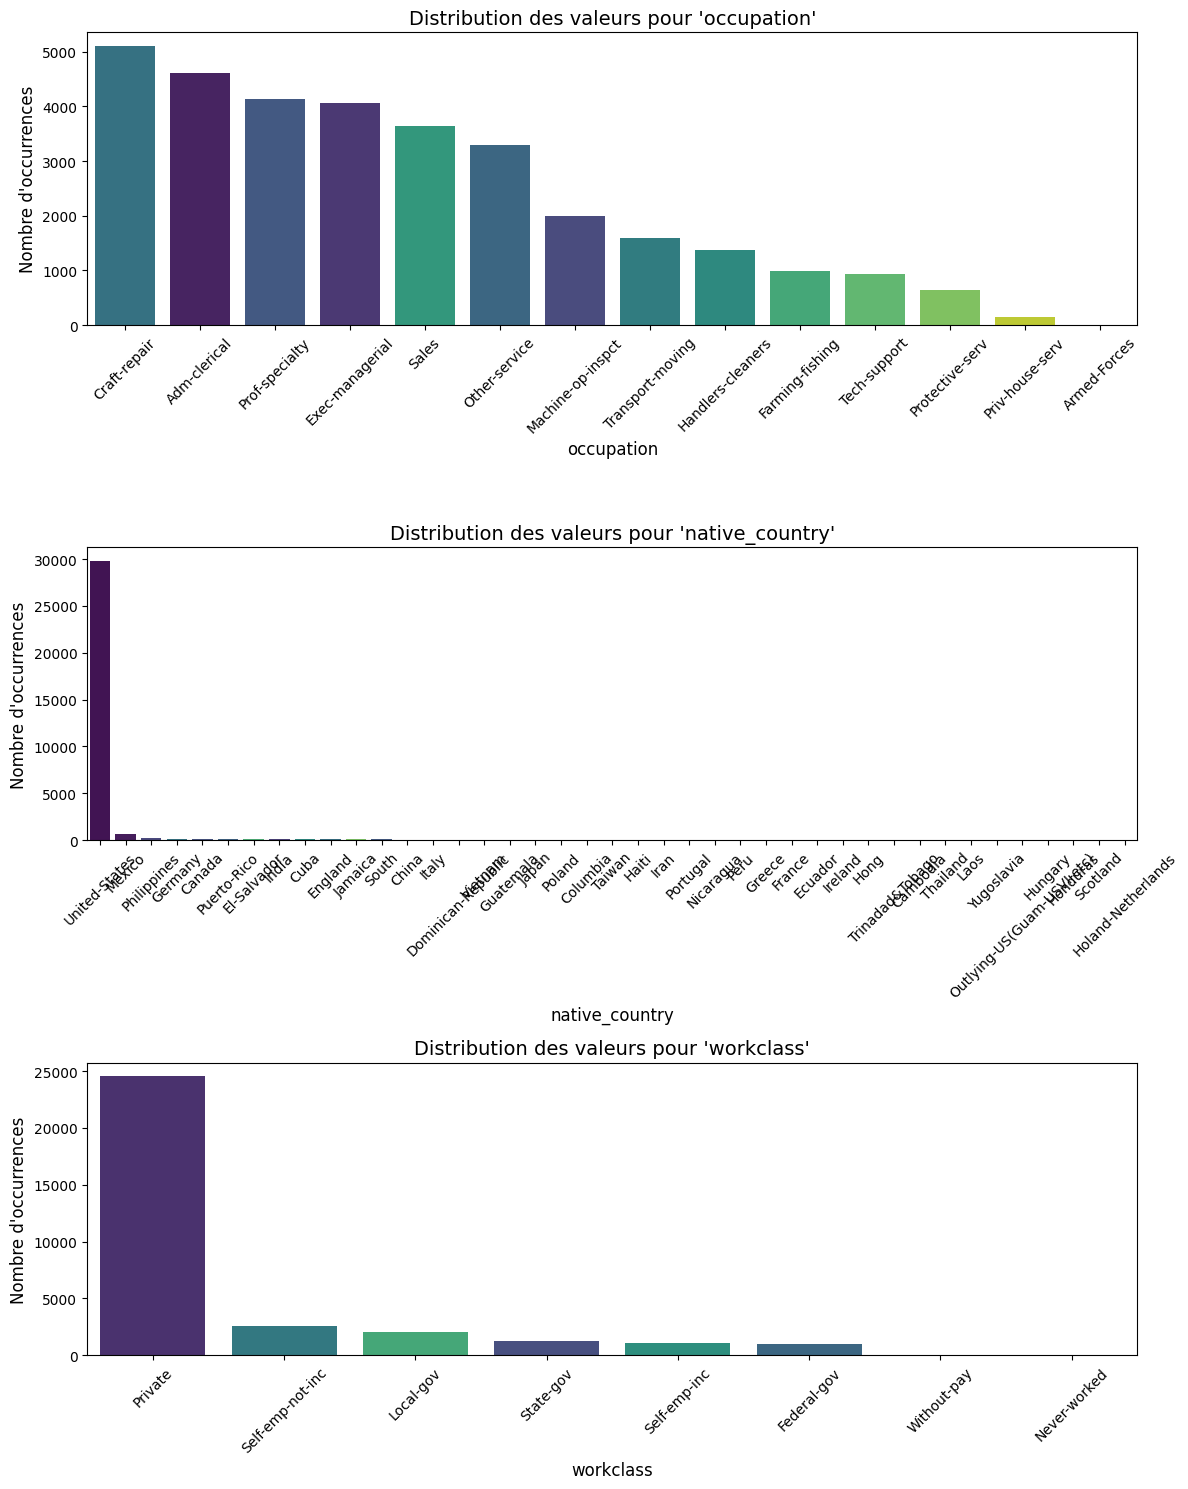

In [ ]:
## distribution values for each categorical column


features = ["occupation","native_country", "workclass"]

# Définir la taille de la figure en fonction du nombre de colonnes catégoriques
num_cols = len(features)
fig, axes = plt.subplots(nrows=num_cols, figsize=(12, 5 * num_cols))

# Si une seule colonne catégorielle, on ajuste pour éviter une erreur d'affichage
if num_cols == 1:
    axes = [axes]

# Création des graphiques avec Seaborn
for ax, col in zip(axes, features):
    sns.countplot(data=df_processing_2, x=col, hue=col, legend=False, order=df_processing_2[col].value_counts().index, palette="viridis", ax=ax)
    ax.set_title(f"Distribution des valeurs pour '{col}'", fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel("Nombre d'occurrences", fontsize=12)
    ax.tick_params(axis='x', rotation=45)  # Rotation des labels pour une meilleure lisibilité

# Ajuster l'espace entre les sous-graphiques
plt.tight_layout()
plt.show()

## c) Encoding

In [ ]:
df_processing_3 = df_processing_2.copy()

In [ ]:
## Do Label encoding on all categorical values

# initialize a dictionary to store the encoders
encoders = {}

# The object columns list
object_columns = df_processing_3.select_dtypes(include=["object"]).columns

# apply label encoding and store the encoders
for column in object_columns:
  label_encoder = LabelEncoder()
  df_processing_3[column] = label_encoder.fit_transform(df_processing_3[column])
  encoders[column] = label_encoder   # saving the encoder for this column


# save the encoders as a pickle file
"""with open("encoders.pkl", "wb") as f:
  pickle.dump(encoders, f)"""

'with open("encoders.pkl", "wb") as f:\n  pickle.dump(encoders, f)'

In [ ]:
encoders

{'workclass': LabelEncoder(),
 'education': LabelEncoder(),
 'marital_status': LabelEncoder(),
 'occupation': LabelEncoder(),
 'relationship': LabelEncoder(),
 'race': LabelEncoder(),
 'sex': LabelEncoder(),
 'native_country': LabelEncoder(),
 'income': LabelEncoder()}

In [ ]:
df_processing_3.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,90,3,11,9,6,0,1,4,0,0,4356,40,38,0
1,82,3,11,9,6,3,1,4,0,0,4356,18,38,0
2,66,3,15,10,6,0,4,2,0,0,4356,40,38,0
3,54,3,5,4,0,6,4,4,0,0,3900,40,38,0
4,41,3,15,10,5,9,3,4,0,0,3900,40,38,0


In [ ]:
df_processing_3.shape

(32561, 14)

In [ ]:
df_processing_3.income.value_counts()

,count
income,
0,24720
1,7841


In [ ]:
df.income.value_counts()

,count
income,
<=50K,24720
>50K,7841


# 5) Modeling

a) 1rst attempt (without SMOTE, normalization/standardization methods, etc)

In [ ]:
df_modeling_1 = df_processing_3.copy()

In [ ]:
# split data into features & target
X = df_modeling_1.drop(columns=['income'])
y = df_modeling_1['income']

In [ ]:
# Split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# print the shape
print(X_train.shape,
      X_test.shape,
      y_train.shape,
      y_test.shape)

(26048, 13) (6513, 13) (26048,) (6513,)


### i) Model training

In [ ]:
# dictionary of classifiers
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

In [ ]:
# dictionary to store the cross validation results
cv_scores = {}

# perform 5-fold cross validation for each model
for model_name, model in models.items():
  print(f"Training {model_name} with default parameters...")
  scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
  cv_scores[model_name] = scores
  print(f"{model_name} Cross-Validation Accuracy: {np.mean(scores):.2f}")
  print("-"*50)

Training Decision Tree with default parameters...
Decision Tree Cross-Validation Accuracy: 0.81
--------------------------------------------------
Training Random Forest with default parameters...
Random Forest Cross-Validation Accuracy: 0.85
--------------------------------------------------
Training XGBoost with default parameters...
XGBoost Cross-Validation Accuracy: 0.87
--------------------------------------------------


In [ ]:
cv_scores

{'Decision Tree': array([0.81477927, 0.81074856, 0.81535509, 0.81915915, 0.80725667]),
 'Random Forest': array([0.84856046, 0.84952015, 0.85834933, 0.84661163, 0.84603571]),
 'XGBoost': array([0.86928983, 0.87044146, 0.87447217, 0.87406412, 0.8640814 ])}

 ### ii) Model Selection & Hyperparameter Tuning

In [ ]:
# Initializing models
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)
xgboost_classifier = XGBClassifier(random_state=42)

In [ ]:
# Hyperparameter grids for RandomizedSearchCV

param_grid_dt = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 10, 20, 30, 50, 70],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}


param_grid_rf = {
    "n_estimators": [50, 100, 200, 500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}


param_grid_xgb = {
    "n_estimators": [50, 100, 200, 500],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.1, 0.2, 0.3],
    "subsample": [0.5, 0.7, 1.0],
    "colsample_bytree": [0.5, 0.7, 1.0]
}


In [ ]:
# Hyperparameter tuning for 3 tree based models

# perform RandomizedSearchCV for each model
random_search_dt = RandomizedSearchCV(estimator=decision_tree, param_distributions=param_grid_dt, n_iter=20, cv=5, scoring="accuracy", random_state=42)
random_search_rf = RandomizedSearchCV(estimator=random_forest, param_distributions=param_grid_rf, n_iter=20, cv=5, scoring="accuracy", random_state=42)
random_search_xgb = RandomizedSearchCV(estimator=xgboost_classifier, param_distributions=param_grid_xgb, n_iter=20, cv=5, scoring="accuracy", random_state=42)


In [ ]:
# fit the models
random_search_dt.fit(X_train, y_train)
random_search_rf.fit(X_train, y_train)
random_search_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=20,
                   param_distributions={'colsample_bytree': [0.5, 0.7, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [50, 100, 200, 500],
                                        'subsample': [0.5, 0.7, 1.0]},
                   random_state=42, scoring='accuracy')

In [ ]:
# Get the model with best score

best_model = None
best_score = 0

if random_search_dt.best_score_ > best_score:
  best_model = random_search_dt.best_estimator_
  best_score = random_search_dt.best_score_

if random_search_rf.best_score_ > best_score:
  best_model = random_search_rf.best_estimator_
  best_score = random_search_rf.best_score_

if random_search_xgb.best_score_ > best_score:
  best_model = random_search_xgb.best_estimator_
  best_score = random_search_xgb.best_score_



In [ ]:
print(f"Best Model: {best_model}")
print(f"Best Cross-Validation Accuracy: {best_score:.2f}")

Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
Best Cross-Validation Accuracy: 0.87


### iii) Evaluation

In [ ]:
# evaluate on test data
y_test_pred = best_model.predict(X_test)
print("Accuracy score:\n", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Accuracy score:
 0.8734838016275142
Confusion Matrix:
 [[4710  266]
 [ 558  979]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92      4976
           1       0.79      0.64      0.70      1537

    accuracy                           0.87      6513
   macro avg       0.84      0.79      0.81      6513
weighted avg       0.87      0.87      0.87      6513



Après nos analyses, on obtient les meilleures performances avec l'algorithme XGBOOSTClasifier, mais au niveau du **"recall"** de la matrice de confusion, on constate qu'on n'a pas de bon résultats ppour la target "1". On peut donc essayer d'optimiser les performances de notre modèle en utilisant la méthode **SMOTE**, car nos deux classes dans notre target columns sont très déséquilibrées.